## Applications - Time Series Prediction

## Imports

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import sys
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from sklearn.metrics import classification_report
from tensorflow.keras import backend as K

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-12.6.5-arm64-arm-64bit
Tensor Flow Version: 2.10.0
Keras Version: 2.10.0

Python 3.9.14 | packaged by conda-forge | (main, Nov 21 2022, 13:20:59) 
[Clang 14.0.6 ]
Pandas 1.5.1
Scikit-Learn 1.1.3
GPU is available


## Read data

In [2]:
csv_file_path = 'AXISBANK_with_indicators_.csv'

df_AXISBANK = pd.read_csv(csv_file_path)
df_AXISBANK

,date,open,high,low,close,volume,sma5,sma10,sma15,sma20,...,fastd,fastksr,fastdsr,ULTOSC,WILLR,ATR,Trange,TYPPRICE,HT_DCPERIOD,BETA
0,2015-02-02 14:30:00+05:30,614.05,614.10,611.40,611.45,93389,613.92,612.765,608.963333,604.7025,...,29.288305,0.000000,8.496577e-01,56.988461,-24.277457,2.824265,2.70,612.316667,31.515298,0.758112
1,2015-02-02 14:35:00+05:30,611.45,611.90,609.10,610.85,167555,612.83,613.000,610.213333,605.6450,...,16.754954,0.000000,4.248289e-01,47.610166,-35.475578,2.822531,2.80,610.616667,30.943413,0.714789
2,2015-02-02 14:40:00+05:30,610.80,611.75,610.40,610.75,159844,612.21,613.290,610.996667,606.5825,...,15.781700,0.000000,3.315866e-14,42.053753,-45.307443,2.717351,1.35,610.966667,30.534145,1.093591
3,2015-02-02 14:45:00+05:30,610.75,612.00,610.10,611.00,59073,611.61,613.505,611.576667,607.5325,...,24.832959,4.144354,1.381451e+00,41.463744,-53.571429,2.658968,1.90,611.033333,30.609989,1.125454
4,2015-02-02 14:50:00+05:30,611.00,612.50,610.60,612.00,62210,611.21,613.135,611.896667,608.5375,...,36.735294,100.000000,3.471478e+01,45.844448,-48.936170,2.604756,1.90,611.700000,31.164563,1.144591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130344,2022-02-18 15:05:00+05:30,787.75,788.00,786.45,787.10,97135,786.37,785.935,786.523333,787.2675,...,56.145210,79.261810,5.975394e+01,52.212669,-48.739496,1.637444,1.55,787.183333,25.002182,0.011385
130345,2022-02-18 15:10:00+05:30,787.15,787.85,786.40,787.20,98721,786.62,786.195,786.356667,787.1400,...,56.380366,84.350488,8.787077e+01,52.953355,-40.000000,1.624055,1.45,787.150000,24.277293,0.038598
130346,2022-02-18 15:15:00+05:30,787.20,787.65,786.10,787.00,165982,786.89,786.330,786.270000,787.0375,...,50.818027,73.084059,7.889879e+01,50.842869,-41.584158,1.618765,1.55,786.916667,23.649002,0.056849
130347,2022-02-18 15:20:00+05:30,786.90,788.00,786.50,788.00,134733,787.36,786.605,786.220000,786.9850,...,56.450170,100.000000,8.581152e+01,55.692888,-21.782178,1.610282,1.50,787.500000,23.000130,0.059598


Each day is 75 time units = 6.25 hours in our data
### Parameters:

In [3]:
mum_units_in_day = 75
num_days_test = 5
weeks_to_exclude = 26

## Pre Process

In [4]:
long_version = True

Select column subset

In [5]:
if long_version:
    # Selecting the required columns
    selected_columns = [
        'open', 'high', 'low', 'close', 'sma5', 'ema5', 'ema20',  'BETA'
    ]

    # Subsetting the DataFrame
    df_AXISBANK = df_AXISBANK[selected_columns]
    df_AXISBANK
else:
    # Selecting the required columns
    selected_columns = [
        'open', 'high', 'low', 'close', 'sma5'
    ]

    # Subsetting the DataFrame
    df_AXISBANK = df_AXISBANK[selected_columns]
    df_AXISBANK

df_AXISBANK

,open,high,low,close,sma5,ema5,ema20,BETA
0,614.05,614.10,611.40,611.45,613.92,613.043855,606.759602,0.758112
1,611.45,611.90,609.10,610.85,612.83,612.312570,607.149164,0.714789
2,610.80,611.75,610.40,610.75,612.21,611.791713,607.492100,1.093591
3,610.75,612.00,610.10,611.00,611.61,611.527809,607.826186,1.125454
4,611.00,612.50,610.60,612.00,611.21,611.685206,608.223692,1.144591
...,...,...,...,...,...,...,...,...
130344,787.75,788.00,786.45,787.10,786.37,786.602462,786.826794,0.011385
130345,787.15,787.85,786.40,787.20,786.62,786.801641,786.862338,0.038598
130346,787.20,787.65,786.10,787.00,786.89,786.867761,786.875448,0.056849
130347,786.90,788.00,786.50,788.00,787.36,787.245174,786.982548,0.059598


Normalize

In [6]:
if long_version:
    # Initialize scaler for all features except 'BETA' and 'close'
    scaler = MinMaxScaler()
    # Fit and transform features, omitting 'BETA' and 'close'
    df_scaled = pd.DataFrame(scaler.fit_transform(df_AXISBANK.drop(columns=['BETA', 'close'])), columns=df_AXISBANK.drop(columns=['BETA', 'close']).columns)

    # Add 'BETA' back unchanged (assuming it's not to be normalized)
    df_scaled['BETA'] = df_AXISBANK['BETA']

    # Initialize a scaler for 'close' (this is so we can reverse this only)
    close_scaler = MinMaxScaler()
    # Fit this scaler to the 'close' column
    df_scaled['close'] = close_scaler.fit_transform(df_AXISBANK[['close']])
else:
    # Initialize scaler for all features except 'close'
    scaler = MinMaxScaler()
    # Fit and transform features, omitting 'close'
    df_scaled = pd.DataFrame(scaler.fit_transform(df_AXISBANK.drop(columns=['close'])), columns=df_AXISBANK.drop(columns=['close']).columns)

    # Initialize a separate scaler for 'close'
    close_scaler = MinMaxScaler()
    # Fit this scaler to the 'close' column
    df_scaled['close'] = close_scaler.fit_transform(df_AXISBANK[['close']])


In [7]:
## exclude 26 weeks for re-training process
df_weekly_retrain = df_scaled.tail(weeks_to_exclude * mum_units_in_day * num_days_test)
df_scaled = df_scaled.head(len(df_scaled) - weeks_to_exclude * mum_units_in_day * num_days_test)
df_scaled

,open,high,low,sma5,ema5,ema20,BETA,close
0,0.562076,0.558119,0.567360,0.564056,0.562665,0.550399,0.758112,0.557461
1,0.557548,0.554274,0.563341,0.562129,0.561366,0.551104,0.714789,0.556417
2,0.556417,0.554012,0.565612,0.561032,0.560441,0.551724,1.093591,0.556242
3,0.556329,0.554449,0.565088,0.559971,0.559972,0.552329,1.125454,0.556678
4,0.556765,0.555322,0.565962,0.559264,0.560252,0.553048,1.144591,0.558419
...,...,...,...,...,...,...,...,...
120594,0.812641,0.812445,0.822645,0.818301,0.820674,0.826307,0.677047,0.814731
120595,0.814818,0.812271,0.822645,0.818336,0.820425,0.826075,0.682231,0.812467
120596,0.812554,0.813145,0.822820,0.819344,0.821117,0.826115,0.593356,0.814992
120597,0.815515,0.813145,0.825266,0.820158,0.821490,0.826126,0.070678,0.814731


Create sequences for models

In [8]:
def create_sequences(df, seq_len):
    xs = []
    ys_binary = []
    ys_continuous = []
    for i in range(len(df) - seq_len):
        x = df.iloc[i:(i + seq_len)].values
        y = (df.iloc[i + seq_len]['close'] > df.iloc[i + seq_len - 1]['close']).astype(int)
        ys_binary.append(y)
        ys_continuous.append(df.iloc[i + seq_len]['close'])
        xs.append(x)
    return np.array(xs), np.array(ys_binary), np.array(ys_continuous)

In [64]:
seq_len = 64  # HyperParam can be played with
X, y_binary, y_continuous = create_sequences(df_scaled, seq_len)

Split to train test

In [65]:
test_size = mum_units_in_day * num_days_test
split_idx = int(len(X) - test_size)

# Manual split using the calculated index to note temporal data
X_train = X[:split_idx]
y_train_binary = y_binary[:split_idx]
y_train_continuous = y_continuous[:split_idx]

X_test = X[split_idx:]
y_test_binary = y_binary[split_idx:]
y_test_continuous = y_continuous[split_idx:]

## Models

In [11]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs  # Residual/Skip connection

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = x + res
    return x  # Residual/Skip connection


In [12]:
def build_transformer_model(input_shape, num_layers, head_size, num_heads, ff_dim, dropout, output_units, activation='linear'):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = GlobalAveragePooling1D()(x)
    x = Dense(20, activation="relu")(x)
    x = Dropout(dropout)(x)
    outputs = Dense(output_units, activation=activation)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

Create Models

In [13]:
num_features = X_train.shape[2]
#model_binary = build_transformer_model(input_shape=(seq_len, num_features), num_layers=3, head_size=128, num_heads=8, ff_dim=64, dropout=0.1, output_units=1, activation='sigmoid')
model_continuous = build_transformer_model(input_shape=(seq_len, num_features), num_layers=3, head_size=128, num_heads=8, ff_dim=64, dropout=0.1, output_units=1, activation='linear')


Metal device set to: Apple M1 Pro


2024-06-08 01:32:58.630804: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-08 01:32:58.631107: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Compile Models

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model_continuous.compile(optimizer=optimizer, loss='mean_squared_error')

Fit Model

In [16]:
# Fit the continuous model
history_continuous_1 = model_continuous.fit(
    X_train, y_train_continuous,
    validation_split=0.05,
    epochs=100,
    batch_size=32,
)

history_continuous_2 = model_continuous.fit(
    X_train, y_train_continuous,
    validation_split=0.05,
    epochs=100,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)]
)

# Combine the histories
history_continuous = {}
for key in history_continuous_1.history.keys():
    history_continuous[key] = history_continuous_1.history[key] + history_continuous_2.history[key]

model_continuous.save('continuous_model.h5')  # Save the continuous model

Epoch 1/100


2024-06-08 01:32:58.999127: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-06-08 01:32:59.801283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3568/3568 [==============================] - ETA: 0s - loss: 0.0064

2024-06-08 01:45:47.347848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3568/3568 [==============================] - 790s 221ms/step - loss: 0.0064 - val_loss: 0.0042
Epoch 2/100
3568/3568 [==============================] - 790s 221ms/step - loss: 0.0015 - val_loss: 0.0059
Epoch 3/100
3568/3568 [==============================] - 783s 220ms/step - loss: 9.0120e-04 - val_loss: 0.0070
Epoch 4/100
3568/3568 [==============================] - 772s 216ms/step - loss: 6.3087e-04 - val_loss: 0.0052
Epoch 5/100
3568/3568 [==============================] - 776s 217ms/step - loss: 4.8520e-04 - val_loss: 0.0055
Epoch 6/100
3568/3568 [==============================] - 775s 217ms/step - loss: 3.9769e-04 - val_loss: 0.0064
Epoch 7/100
3568/3568 [==============================] - 771s 216ms/step - loss: 3.3853e-04 - val_loss: 0.0054
Epoch 8/100
3568/3568 [==============================] - 769s 216ms/step - loss: 2.9583e-04 - val_loss: 0.0064
Epoch 9/100
3568/3568 [==============================] - 770s 216ms/step - loss: 2.6569e-04 - val_loss: 0.0064
Epoch 10/100
3568/356

3568/3568 [==============================] - 673s 189ms/step - loss: 6.9065e-05 - val_loss: 0.0065
Epoch 48/100
3568/3568 [==============================] - 672s 188ms/step - loss: 6.8748e-05 - val_loss: 0.0068
Epoch 49/100
3568/3568 [==============================] - 671s 188ms/step - loss: 6.8730e-05 - val_loss: 0.0064
Epoch 50/100
3568/3568 [==============================] - 673s 189ms/step - loss: 6.8479e-05 - val_loss: 0.0065
Epoch 51/100
3568/3568 [==============================] - 672s 188ms/step - loss: 6.8759e-05 - val_loss: 0.0061
Epoch 52/100
3568/3568 [==============================] - 673s 189ms/step - loss: 6.8631e-05 - val_loss: 0.0069
Epoch 53/100
3568/3568 [==============================] - 670s 188ms/step - loss: 6.8605e-05 - val_loss: 0.0067
Epoch 54/100
3568/3568 [==============================] - 670s 188ms/step - loss: 6.8178e-05 - val_loss: 0.0061
Epoch 55/100
3568/3568 [==============================] - 671s 188ms/step - loss: 6.8248e-05 - val_loss: 0.0070
Epoch

Get Predictions + Load Models

In [18]:
model_continuous = tf.keras.models.load_model('continuous_model.h5')

In [66]:
y_pred_continuous = model_continuous.predict(X_test)
# Convert continuous predictions to binary predictions for evaluation
y_pred_binary_from_cont = (y_pred_continuous[:-1] < y_pred_continuous[1:]).astype(int)

12/12 [==============================] - 1s 88ms/step


## Evaluations

In [67]:
# Evaluate continuous model converted to binary
print("Continuous Model Converted to Binary Classification Report:")
print(classification_report(y_test_binary[:-1], y_pred_binary_from_cont))


Continuous Model Converted to Binary Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.54      0.58       204
           1       0.53      0.63      0.58       170

    accuracy                           0.58       374
   macro avg       0.58      0.58      0.58       374
weighted avg       0.59      0.58      0.58       374



## Visualizations

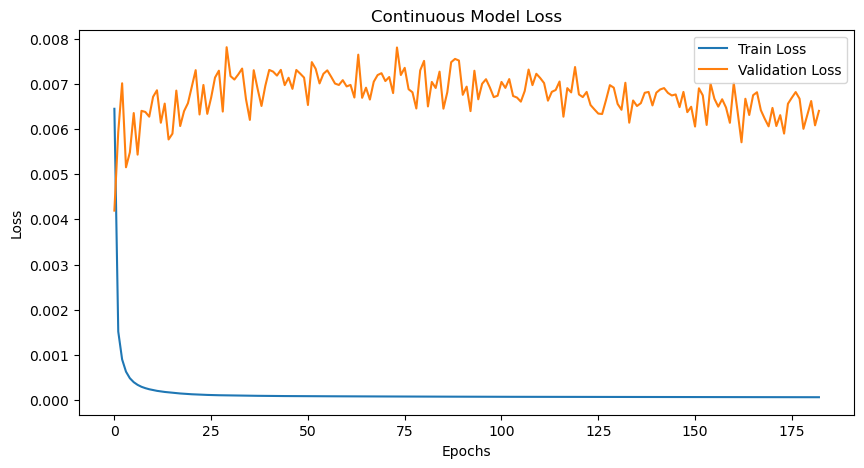

In [26]:
# Plot training and validation loss for the continuous model
plt.figure(figsize=(10, 5))
plt.plot(history_continuous['loss'], label='Train Loss')
plt.plot(history_continuous['val_loss'], label='Validation Loss')
plt.title('Continuous Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


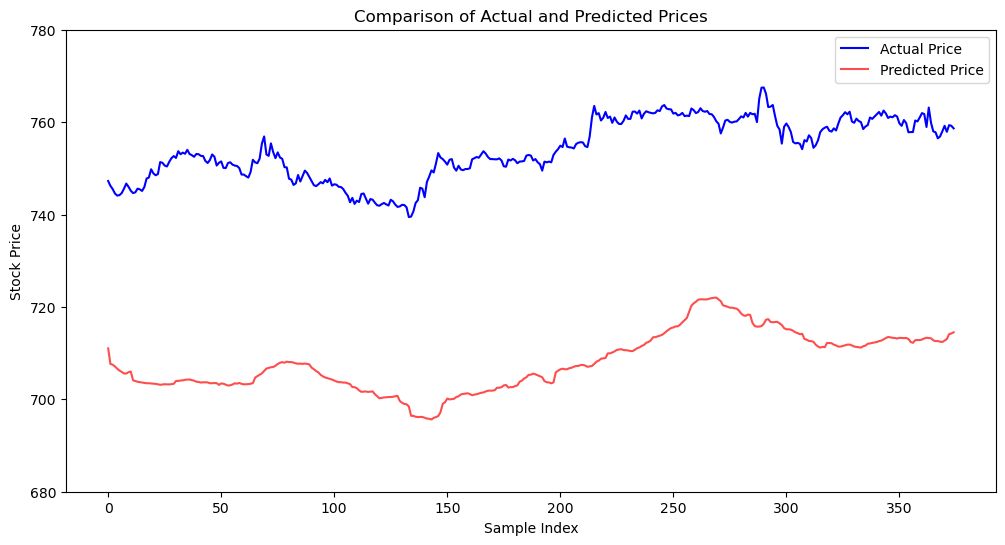

In [25]:
# Rescale the outputs back to the original scale
y_test_continuous_rescaled = close_scaler.inverse_transform(y_test_continuous.reshape(-1, 1))
y_pred_continuous_rescaled = close_scaler.inverse_transform(y_pred_continuous.reshape(-1, 1))

# Visualization of prediction vs actual for the continuous model
plt.figure(figsize=(12, 6))
plt.plot(y_test_continuous_rescaled, label='Actual Price', color='blue')
plt.plot(y_pred_continuous_rescaled, label='Predicted Price', color='red', alpha=0.7)
plt.title('Comparison of Actual and Predicted Prices')
plt.xlabel('Sample Index')
plt.ylabel('Stock Price')
plt.legend()
plt.ylim(680, 780)
plt.show()

Continous

In [27]:
init_amount = 10000

In [28]:
def continuous_trading_strategy(init_amount, y_test_continuous_rescaled, y_pred_continuous_rescaled):
    current_balance = init_amount
    stock_units = 0
    num_buys = 0
    num_sells = 0
    total_minutes = (len(y_pred_continuous_rescaled) - 1) * 5  # Each time unit is 5 minutes


    for i in range(len(y_pred_continuous_rescaled) - 1):
        current_price = y_test_continuous_rescaled[i][0]
        current_prediction = y_pred_continuous_rescaled[i][0]
        next_prediction = y_pred_continuous_rescaled[i + 1][0]

        if next_prediction > current_prediction:  # Predicted to go up
            if current_balance >= current_price:  # Check if there's enough balance to buy one unit
                stock_units += 1  # Buy one unit
                current_balance -= current_price  # Subtract the cost of one unit from the balance
                num_buys += 1
            else:
                continue
        elif next_prediction < current_prediction:  # Predicted to go down
            if stock_units > 0:
                current_balance += stock_units * current_price  # Sell all units
                stock_units = 0
                num_sells += 1
                
        

    # Sell any remaining stock units at the last known price
    final_price = y_test_continuous_rescaled[-1][0]
    if stock_units > 0:
        current_balance += stock_units * final_price
        stock_units = 0
        num_sells += 1

    gain_loss_percent = ((current_balance - init_amount) / init_amount) * 100
    
    trading_hours = total_minutes / 60  # Convert total trading minutes to hours

    # Baseline scenario: Buy at the first and sell at the last price
    baseline_first_price = y_test_continuous_rescaled[0][0]
    baseline_final_price = y_test_continuous_rescaled[-1][0]
    baseline_units = init_amount / baseline_first_price
    baseline_final_balance = baseline_units * baseline_final_price
    baseline_gain_loss_percent = ((baseline_final_balance - init_amount) / init_amount) * 100

    print(f"Initial Amount: {init_amount}")
    print(f"Final Balance: {current_balance: .3f}")
    print(f"Total Transactions: {num_buys + num_sells}")
    print(f"Buys: {num_buys}, Sells: {num_sells}")
    print(f"Trading Duration: {trading_hours:.2f} hours")
    if (num_buys + num_sells) > 0:
        print(f"Trades per hour: {(num_buys + num_sells) / trading_hours}")
        print(f"Mean Gain/Loss Percentage per transaction: {gain_loss_percent/(num_buys + num_sells):.5f}%")
    print(f"Gain/Loss Percentage: {gain_loss_percent:.2f}%")
    print("Baseline Scenario:")
    print(f"Baseline Gain/Loss Percentage: {baseline_gain_loss_percent:.2f}%")


In [29]:
continuous_trading_strategy(init_amount, y_test_continuous_rescaled, y_pred_continuous_rescaled)

Initial Amount: 10000
Final Balance:  9954.850
Total Transactions: 221
Buys: 177, Sells: 44
Trading Duration: 31.17 hours
Trades per hour: 7.090909090909091
Mean Gain/Loss Percentage per transaction: -0.00204%
Gain/Loss Percentage: -0.45%
Baseline Scenario:
Baseline Gain/Loss Percentage: 1.53%


In [30]:
def visualize_trading_strategy_continuous(init_amount, y_test_continuous_rescaled, y_pred_continuous_rescaled):
    current_balance = init_amount
    stock_units = 0
    num_buys = 0
    num_sells = 0
    balance_history = [current_balance]
    stock_units_history = [stock_units]
    timestamps = list(range(len(y_pred_continuous_rescaled) + 1))
    buy_points = []
    sell_points = []

    for i in range(len(y_pred_continuous_rescaled) - 1):
        current_price = y_test_continuous_rescaled[i][0]
        current_prediction = y_pred_continuous_rescaled[i][0]
        next_prediction = y_pred_continuous_rescaled[i + 1][0]

        if next_prediction > current_prediction:  # Predicted to go up
            if current_balance >= current_price:  # Check if there's enough balance to buy one unit
                stock_units += 1  # Buy one unit
                current_balance -= current_price  # Subtract the cost of one unit from the balance
                num_buys += 1
                buy_points.append(i)
        elif next_prediction < current_prediction:  # Predicted to go down
            if stock_units > 0:
                current_balance += stock_units * current_price  # Sell all units
                stock_units = 0
                num_sells += 1
                sell_points.append(i)
        
        balance_history.append(current_balance + stock_units * current_price)
        stock_units_history.append(stock_units)

    # Sell any remaining stock units at the last known price
    final_price = y_test_continuous_rescaled[-1][0]
    if stock_units > 0:
        current_balance += stock_units * final_price
        stock_units = 0
        num_sells += 1
        sell_points.append(len(y_pred_continuous_rescaled) - 1)

    balance_history.append(current_balance + stock_units * current_price)
    stock_units_history.append(stock_units)

    gain_loss_percent = ((current_balance - init_amount) / init_amount) * 100

    # Plot the stock price
    plt.figure(figsize=(14, 10))

    plt.subplot(3, 1, 1)
    plt.plot(timestamps[:-1], [price[0] for price in y_test_continuous_rescaled], label='Actual Price')
    plt.scatter(buy_points, [y_test_continuous_rescaled[i][0] for i in buy_points], color='green', label='Buy', marker='^', s=100)
    plt.scatter(sell_points, [y_test_continuous_rescaled[i][0] for i in sell_points], color='red', label='Sell', marker='v', s=100)
    plt.title('Stock Price and Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()

    # Plot the account balance
    plt.subplot(3, 1, 2)
    plt.plot(timestamps, balance_history, label='Balance')
    plt.title('Account Balance Over Time')
    plt.xlabel('Time')
    plt.ylabel('Balance')
    plt.legend()

    # Plot the number of stock units held
    plt.subplot(3, 1, 3)
    plt.plot(timestamps, stock_units_history, label='Stock Units Held')
    plt.title('Stock Units Held Over Time')
    plt.xlabel('Time')
    plt.ylabel('Stock Units')
    plt.legend()

    plt.tight_layout()
    plt.show()


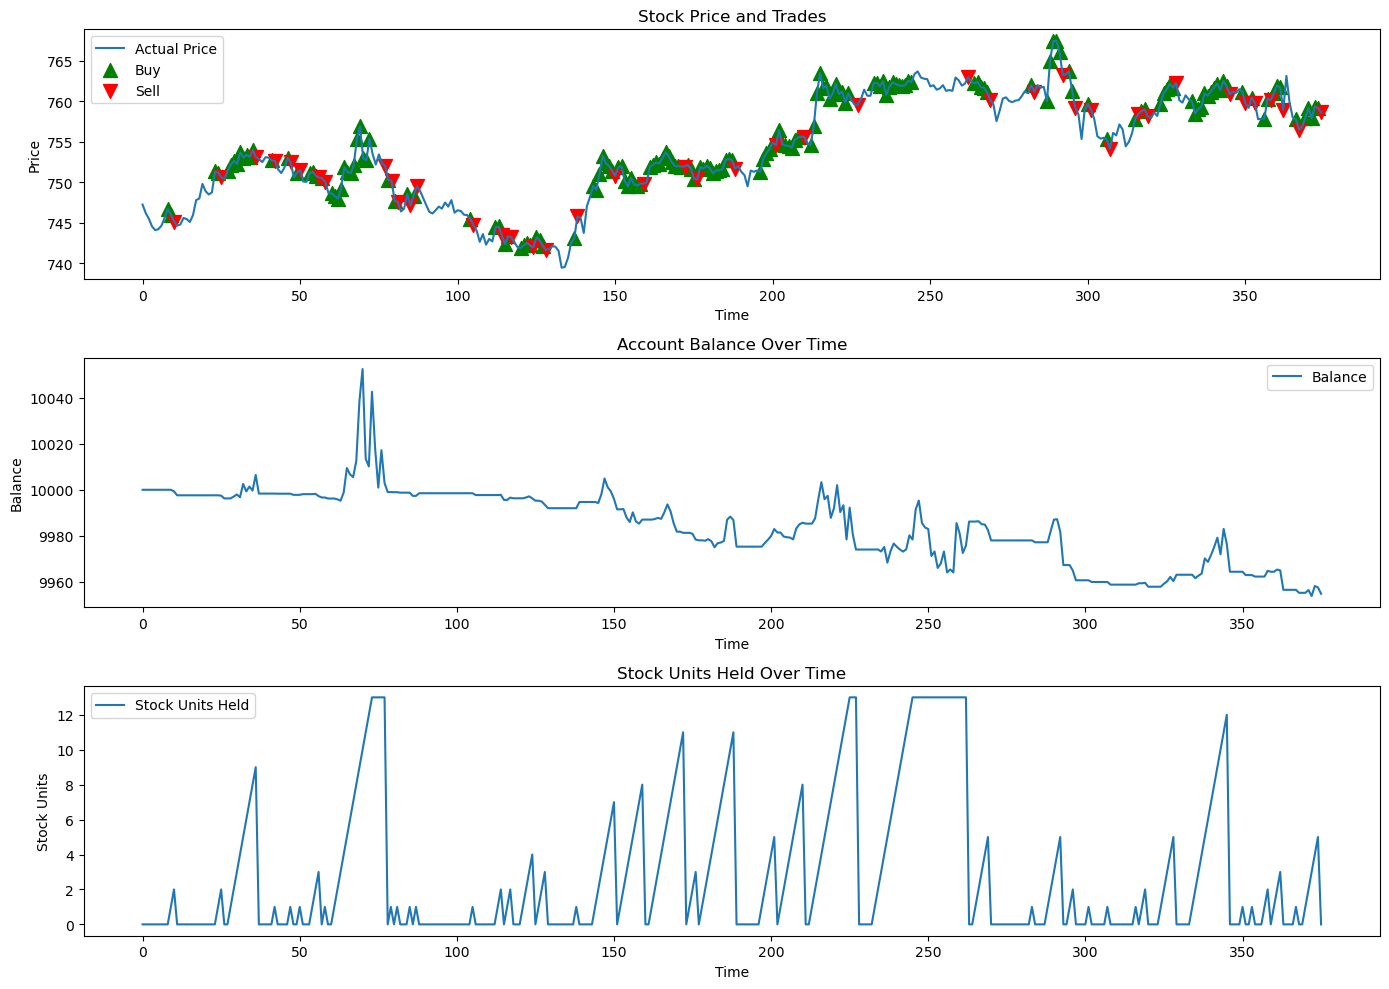

In [31]:
visualize_trading_strategy_continuous(init_amount, y_test_continuous_rescaled, y_pred_continuous_rescaled)

## Re train periods
#### Continuous

In [42]:
# Initialize lists to store predictions
predictions_no_retraining = []
predictions_with_retraining = []

In [43]:
# Initial clone of the model for no retraining scenario
model_no_retraining = tf.keras.models.clone_model(model_continuous)
model_no_retraining.set_weights(model_continuous.get_weights())

In [44]:
X, _, y = create_sequences(df_weekly_retrain, seq_len)

In [45]:
fine_tune_learning_rate = 1e-6  # Smaller learning rate for fine-tuning
optimizer = tf.keras.optimizers.Adam(learning_rate=fine_tune_learning_rate)
model_continuous.compile(optimizer=optimizer, loss='mean_squared_error')

Fine tuning using rolling window

In [46]:
rolling_window_size = 3 * mum_units_in_day * 5  # Rolling window size of 3 weeks

In [47]:
# Loop through each week
for week in range(weeks_to_exclude):
    # Calculate the indices for the current week's data
    start_idx = week * test_size
    end_idx = start_idx + test_size
    
    # Extract the test data for the current week
    X_test_week = X[start_idx:end_idx]
    y_test_week = y[start_idx:end_idx]
    
    # Predict without re-training
    pred_no_retrain = model_no_retraining.predict(X_test_week).T[0]
    predictions_no_retraining.append(pred_no_retrain)
    
    if week != 0:
        # For fine-tuning, use data up to the start of the current week's data
        rolling_start_idx = max(0, start_idx - rolling_window_size)

        # Extract the rolling window data (up to the start of the current week)
        X_train_week = X[rolling_start_idx:start_idx]
        y_train_week = y[rolling_start_idx:start_idx]


        # Fine-tune the model on the rolling window data (up to the start of the current week)
        model_continuous.fit(
            X_train_week, y_train_week,
            validation_split=0.15,  # Use the last 15% of the data for validation
            epochs=50,  # Fewer epochs for fine-tuning
            batch_size=32,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
        )

    # Predict with re-training
    pred_with_retrain = model_continuous.predict(X_test_week).T[0]
    predictions_with_retraining.append(pred_with_retrain)

    # Save the updated model after each week's training
    model_continuous.save(f'continuous_model_week_{week + 1}.h5')


2024-06-09 14:43:41.289690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 114ms/step


2024-06-09 14:43:43.094401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 89ms/step
Epoch 1/50


2024-06-09 14:43:46.767539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.0034

2024-06-09 14:43:50.472428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 5s 357ms/step - loss: 0.0034 - val_loss: 0.0053
Epoch 2/50
10/10 [==============================] - 2s 229ms/step - loss: 6.3011e-05 - val_loss: 0.0057
Epoch 3/50
10/10 [==============================] - 2s 210ms/step - loss: 5.5092e-05 - val_loss: 0.0061
Epoch 4/50
10/10 [==============================] - 2s 216ms/step - loss: 5.1775e-05 - val_loss: 0.0062
Epoch 5/50
10/10 [==============================] - 2s 206ms/step - loss: 5.2017e-05 - val_loss: 0.0062
Epoch 6/50
12/12 [==============================] - 1s 92ms/step
Epoch 1/50
20/20 [==============================] - 5s 252ms/step - loss: 6.4027e-05 - val_loss: 0.0068
Epoch 2/50
20/20 [==============================] - 4s 210ms/step - loss: 4.5698e-05 - val_loss: 0.0070
Epoch 3/50
20/20 [==============================] - 4s 203ms/step - loss: 4.2178e-05 - val_loss: 0.0069
Epoch 4/50
20/20 [==============================] - 4s 206ms/step - loss: 4.3641e-05 - val_loss: 0.0069
Epoch 5/50
20/

30/30 [==============================] - 6s 203ms/step - loss: 3.4360e-05 - val_loss: 0.0046
Epoch 4/50
30/30 [==============================] - 6s 203ms/step - loss: 3.3982e-05 - val_loss: 0.0046
Epoch 5/50
30/30 [==============================] - 6s 205ms/step - loss: 3.4365e-05 - val_loss: 0.0047
Epoch 6/50
30/30 [==============================] - 6s 200ms/step - loss: 3.4023e-05 - val_loss: 0.0047
Epoch 7/50
30/30 [==============================] - 6s 201ms/step - loss: 3.3121e-05 - val_loss: 0.0047
Epoch 8/50
12/12 [==============================] - 1s 90ms/step
Epoch 1/50
30/30 [==============================] - 6s 205ms/step - loss: 5.3861e-05 - val_loss: 0.0046
Epoch 2/50
30/30 [==============================] - 6s 204ms/step - loss: 4.9722e-05 - val_loss: 0.0047
Epoch 3/50
30/30 [==============================] - 6s 202ms/step - loss: 4.7781e-05 - val_loss: 0.0047
Epoch 4/50
30/30 [==============================] - 6s 201ms/step - loss: 4.8071e-05 - val_loss: 0.0048
Epoch 5/50

In [48]:
# Flatten the predictions and true values for comparison
predictions_no_retraining_flat = np.concatenate(predictions_no_retraining)
predictions_with_retraining_flat = np.concatenate(predictions_with_retraining)
y_test_continuous_flat = np.concatenate([y[i * test_size: (i + 1) * test_size] for i in range(weeks_to_exclude)])

In [49]:
# Assuming you have a scaler to inverse transform the predictions and true values
y_test_continuous_rescaled = close_scaler.inverse_transform(y_test_continuous_flat.reshape(-1, 1))
predictions_no_retraining_rescaled = close_scaler.inverse_transform(predictions_no_retraining_flat.reshape(-1, 1))
predictions_with_retraining_rescaled = close_scaler.inverse_transform(predictions_with_retraining_flat.reshape(-1, 1))

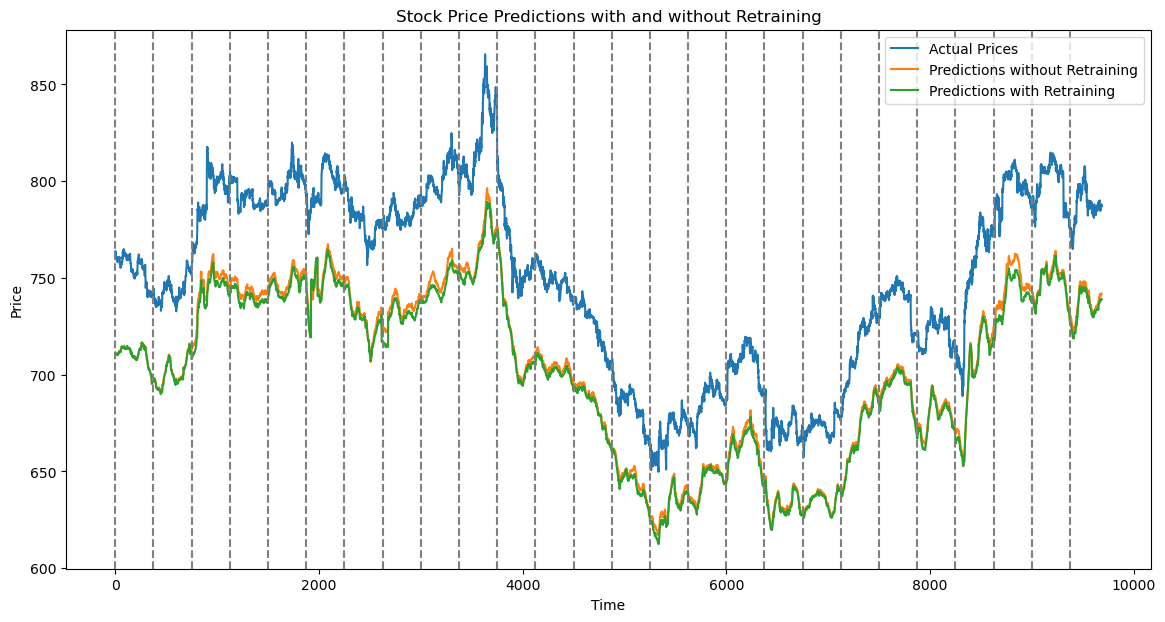

In [50]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_continuous_rescaled, label='Actual Prices')
plt.plot(predictions_no_retraining_rescaled, label='Predictions without Retraining')
plt.plot(predictions_with_retraining_rescaled, label='Predictions with Retraining')

# Add vertical lines to split weeks
for week in range(weeks_to_exclude):
    plt.axvline(x=week * test_size, color='gray', linestyle='--')

plt.title('Stock Price Predictions with and without Retraining')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [51]:
print("Without Retraining:")
continuous_trading_strategy(init_amount, y_test_continuous_rescaled, predictions_no_retraining_rescaled)
print()
print("With Retraining:")
continuous_trading_strategy(init_amount, y_test_continuous_rescaled, predictions_with_retraining_rescaled)

Without Retraining:
Initial Amount: 10000
Final Balance:  10251.800
Total Transactions: 5463
Buys: 4270, Sells: 1193
Trading Duration: 807.08 hours
Trades per hour: 6.768817759421786
Mean Gain/Loss Percentage per transaction: 0.00046%
Gain/Loss Percentage: 2.52%
Baseline Scenario:
Baseline Gain/Loss Percentage: 3.18%

With Retraining:
Initial Amount: 10000
Final Balance:  10492.400
Total Transactions: 5458
Buys: 4264, Sells: 1194
Trading Duration: 807.08 hours
Trades per hour: 6.762622612287042
Mean Gain/Loss Percentage per transaction: 0.00090%
Gain/Loss Percentage: 4.92%
Baseline Scenario:
Baseline Gain/Loss Percentage: 3.18%


Without Retraining:


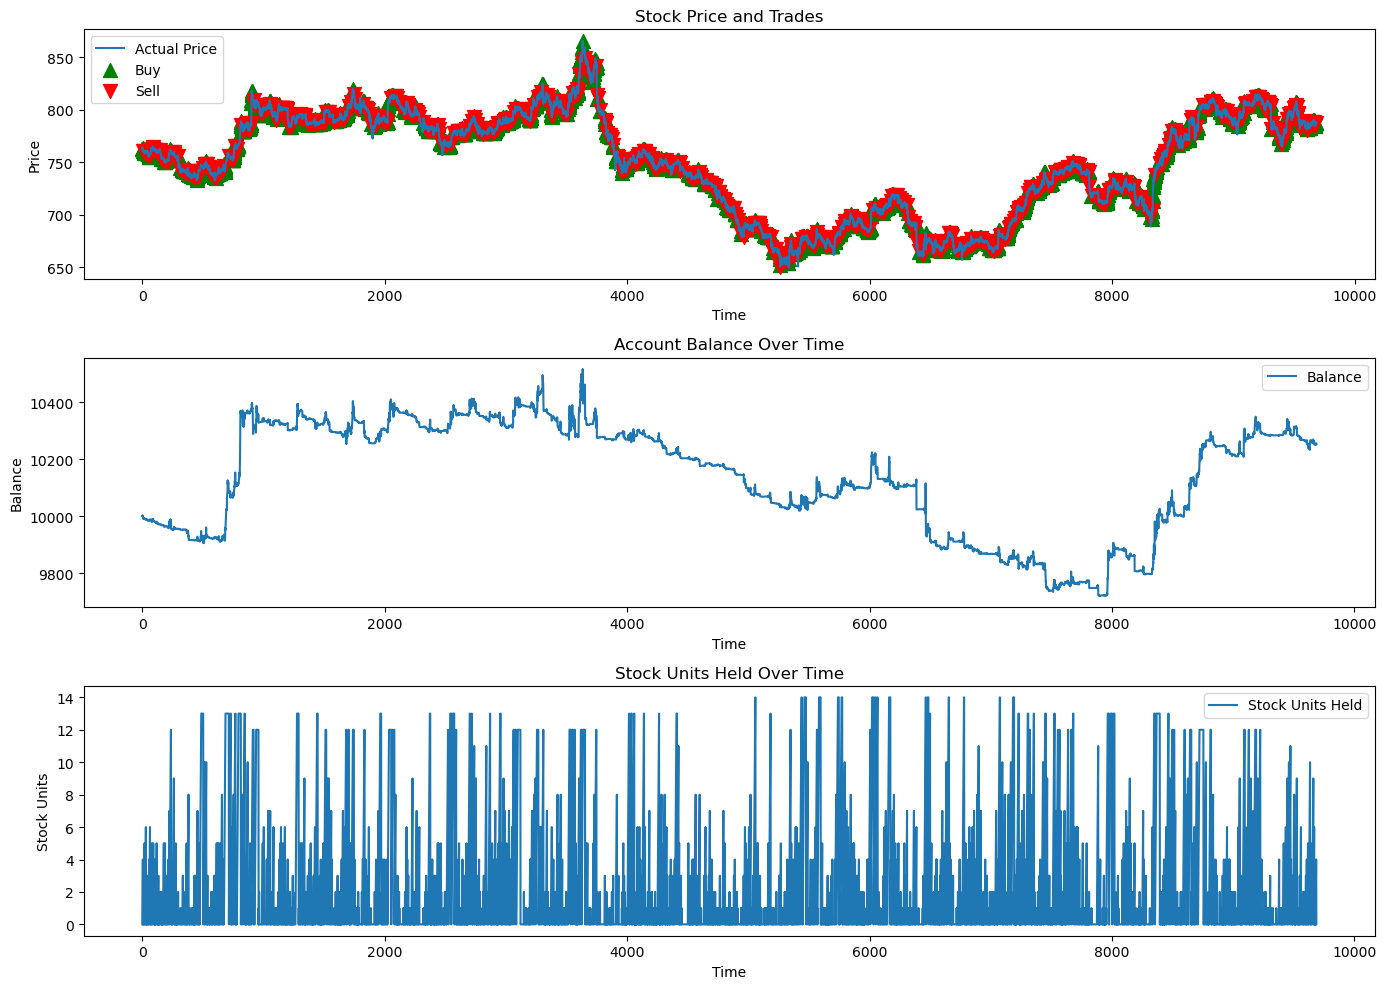


With Retraining:


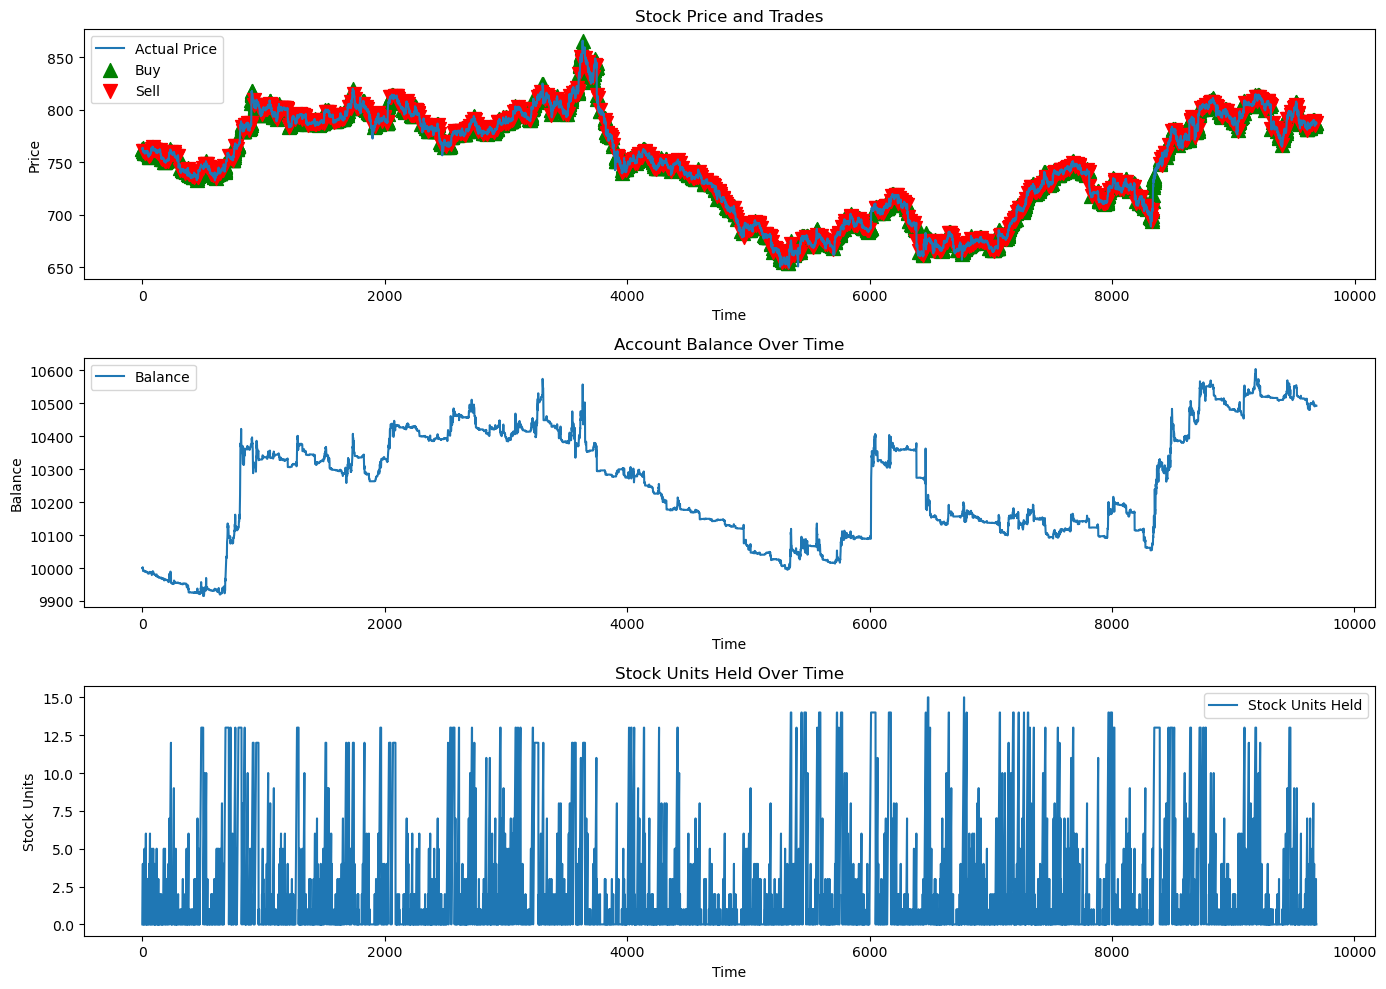

In [52]:
print("Without Retraining:")
visualize_trading_strategy_continuous(init_amount, y_test_continuous_rescaled, predictions_no_retraining_rescaled)
print()
print("With Retraining:")
visualize_trading_strategy_continuous(init_amount, y_test_continuous_rescaled, predictions_with_retraining_rescaled)

Second week (one retrain only)

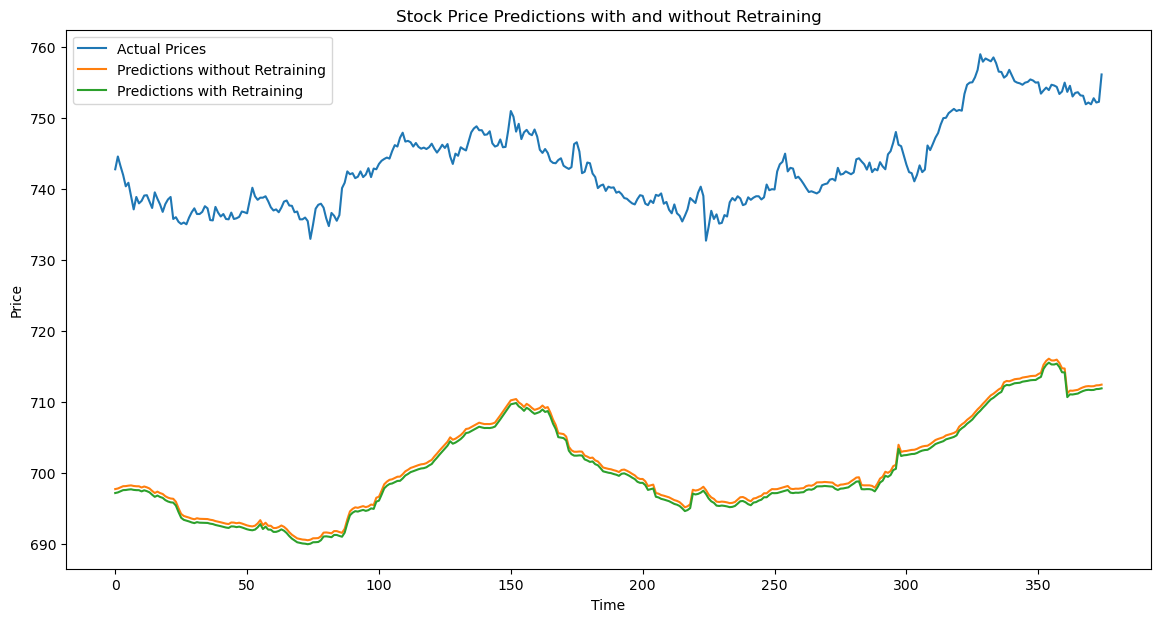

In [53]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_continuous_rescaled[375:375*2], label='Actual Prices')
plt.plot(predictions_no_retraining_rescaled[375:375*2], label='Predictions without Retraining')
plt.plot(predictions_with_retraining_rescaled[375:375*2], label='Predictions with Retraining')


plt.title('Stock Price Predictions with and without Retraining')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

Without Retraining:


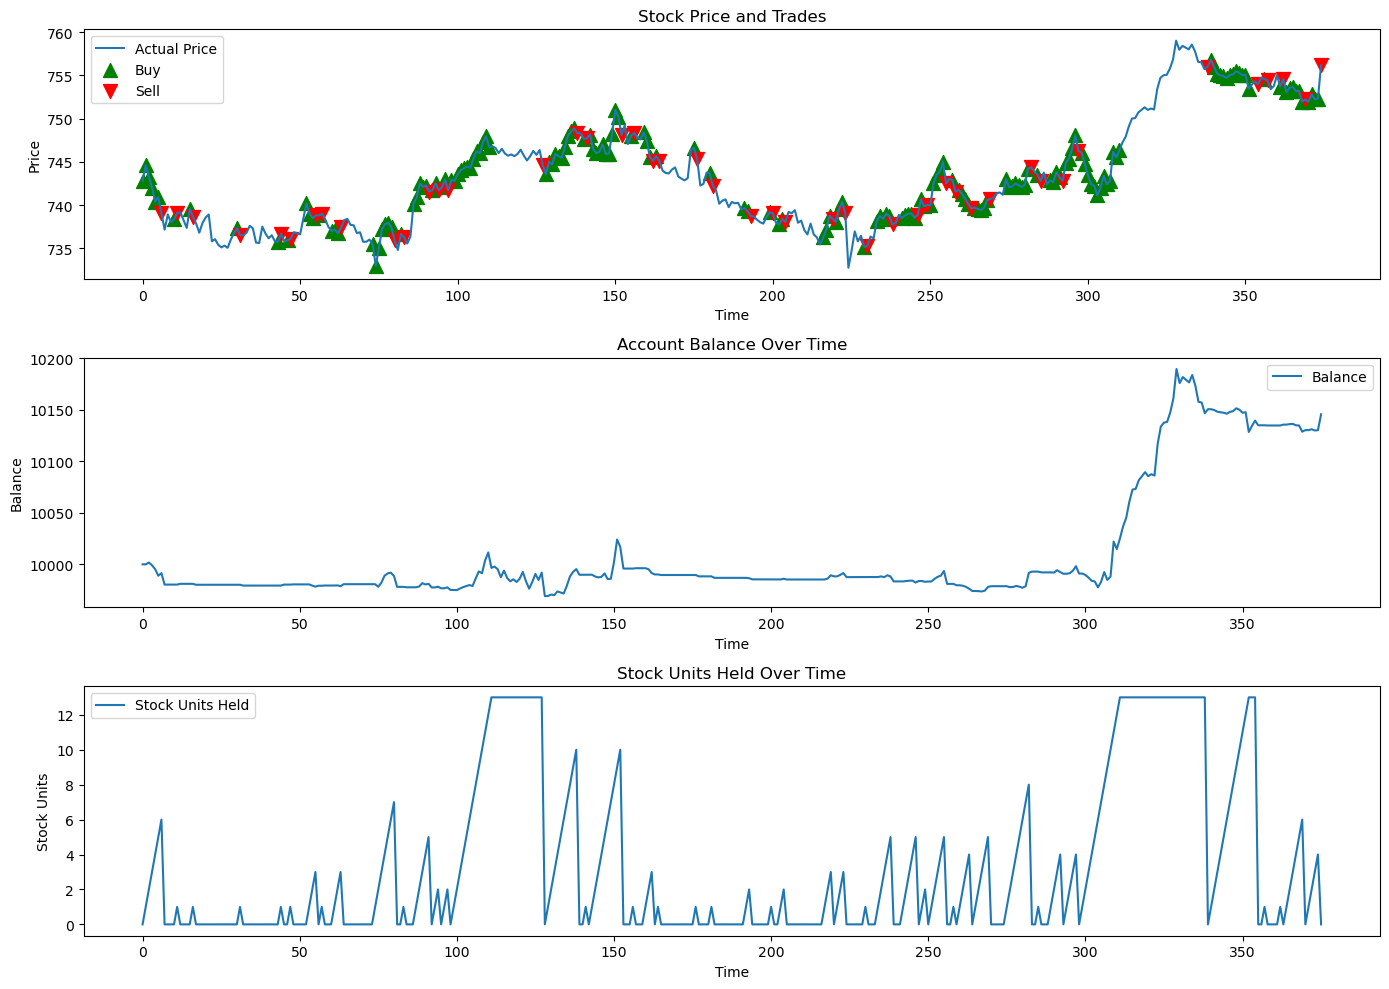


With Retraining:


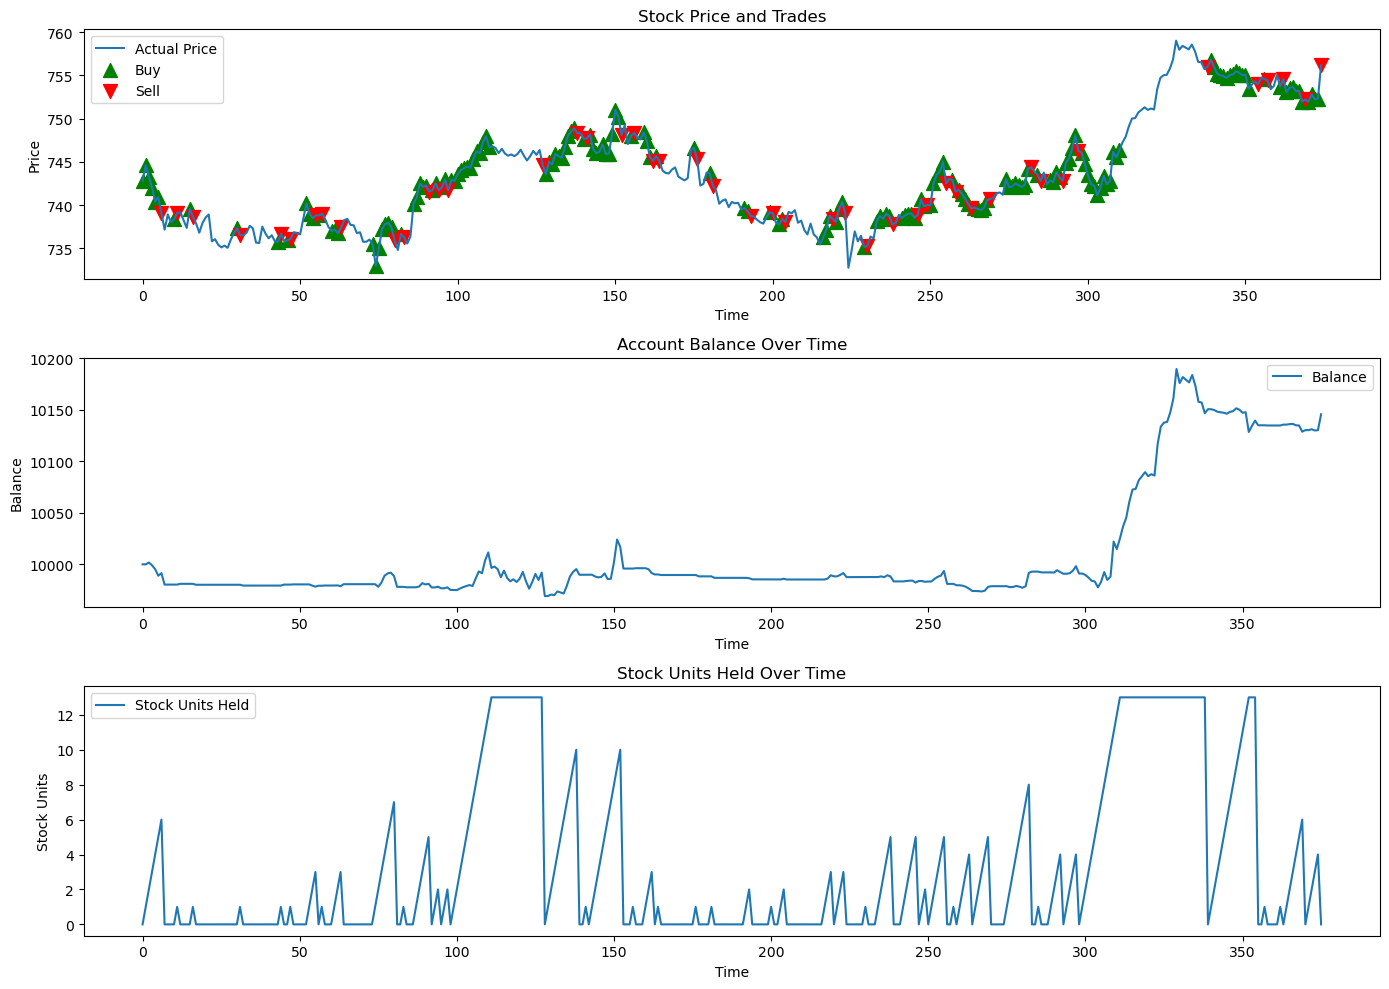

In [54]:
print("Without Retraining:")
visualize_trading_strategy_continuous(init_amount, y_test_continuous_rescaled[test_size:test_size*2], predictions_no_retraining_rescaled[test_size:test_size*2])
print()
print("With Retraining:")
visualize_trading_strategy_continuous(init_amount, y_test_continuous_rescaled[test_size:test_size*2], predictions_with_retraining_rescaled[test_size:test_size*2])

In [55]:
print("Without Retraining:")
continuous_trading_strategy(init_amount, y_test_continuous_rescaled[test_size:test_size*2], predictions_no_retraining_rescaled[test_size:test_size*2])
print()
print("With Retraining:")
continuous_trading_strategy(init_amount, y_test_continuous_rescaled[test_size:test_size*2], predictions_with_retraining_rescaled[test_size:test_size*2])

Without Retraining:
Initial Amount: 10000
Final Balance:  10145.600
Total Transactions: 216
Buys: 170, Sells: 46
Trading Duration: 31.17 hours
Trades per hour: 6.93048128342246
Mean Gain/Loss Percentage per transaction: 0.00674%
Gain/Loss Percentage: 1.46%
Baseline Scenario:
Baseline Gain/Loss Percentage: 1.80%

With Retraining:
Initial Amount: 10000
Final Balance:  10145.600
Total Transactions: 216
Buys: 170, Sells: 46
Trading Duration: 31.17 hours
Trades per hour: 6.93048128342246
Mean Gain/Loss Percentage per transaction: 0.00674%
Gain/Loss Percentage: 1.46%
Baseline Scenario:
Baseline Gain/Loss Percentage: 1.80%


last week

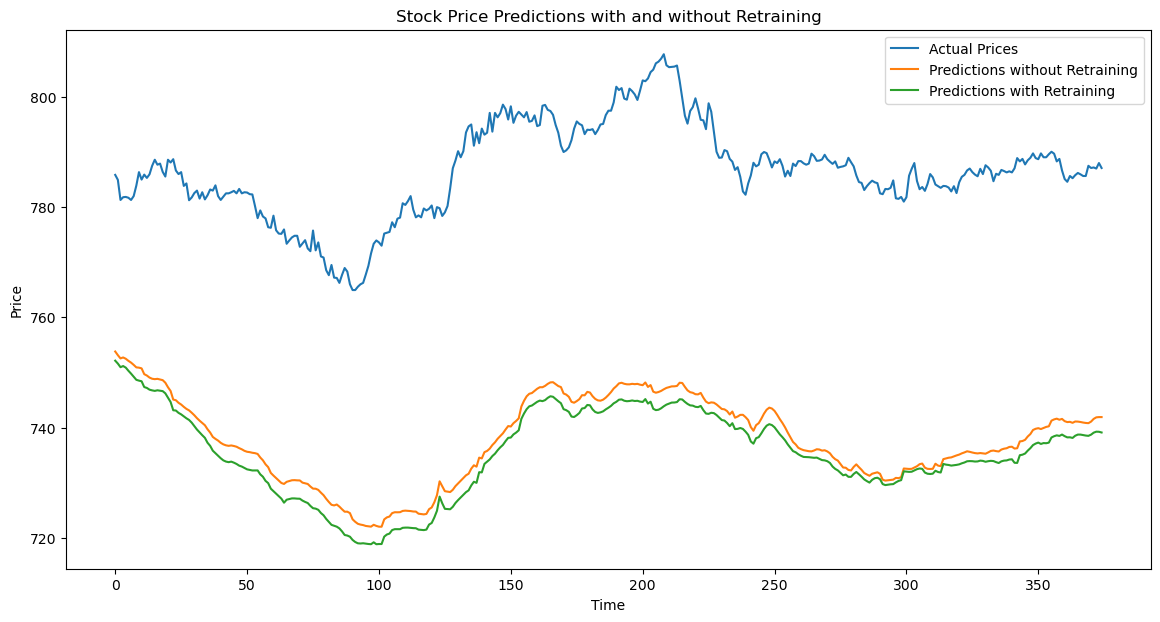

In [56]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_continuous_rescaled[-375:], label='Actual Prices')
plt.plot(predictions_no_retraining_rescaled[-375:], label='Predictions without Retraining')
plt.plot(predictions_with_retraining_rescaled[-375:], label='Predictions with Retraining')


plt.title('Stock Price Predictions with and without Retraining')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

Without Retraining:


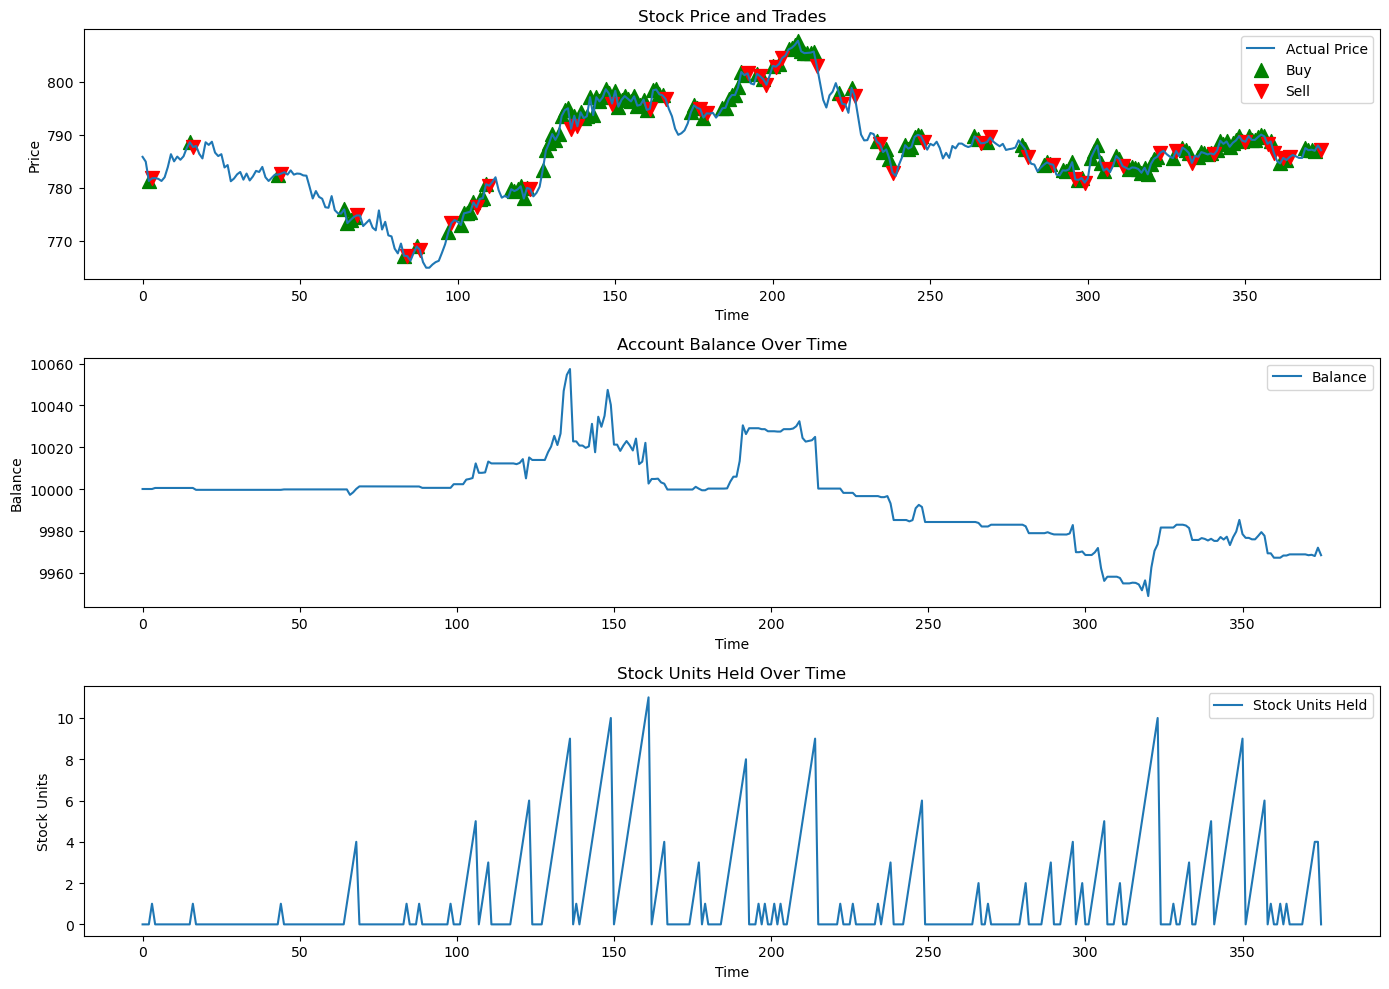


With Retraining:


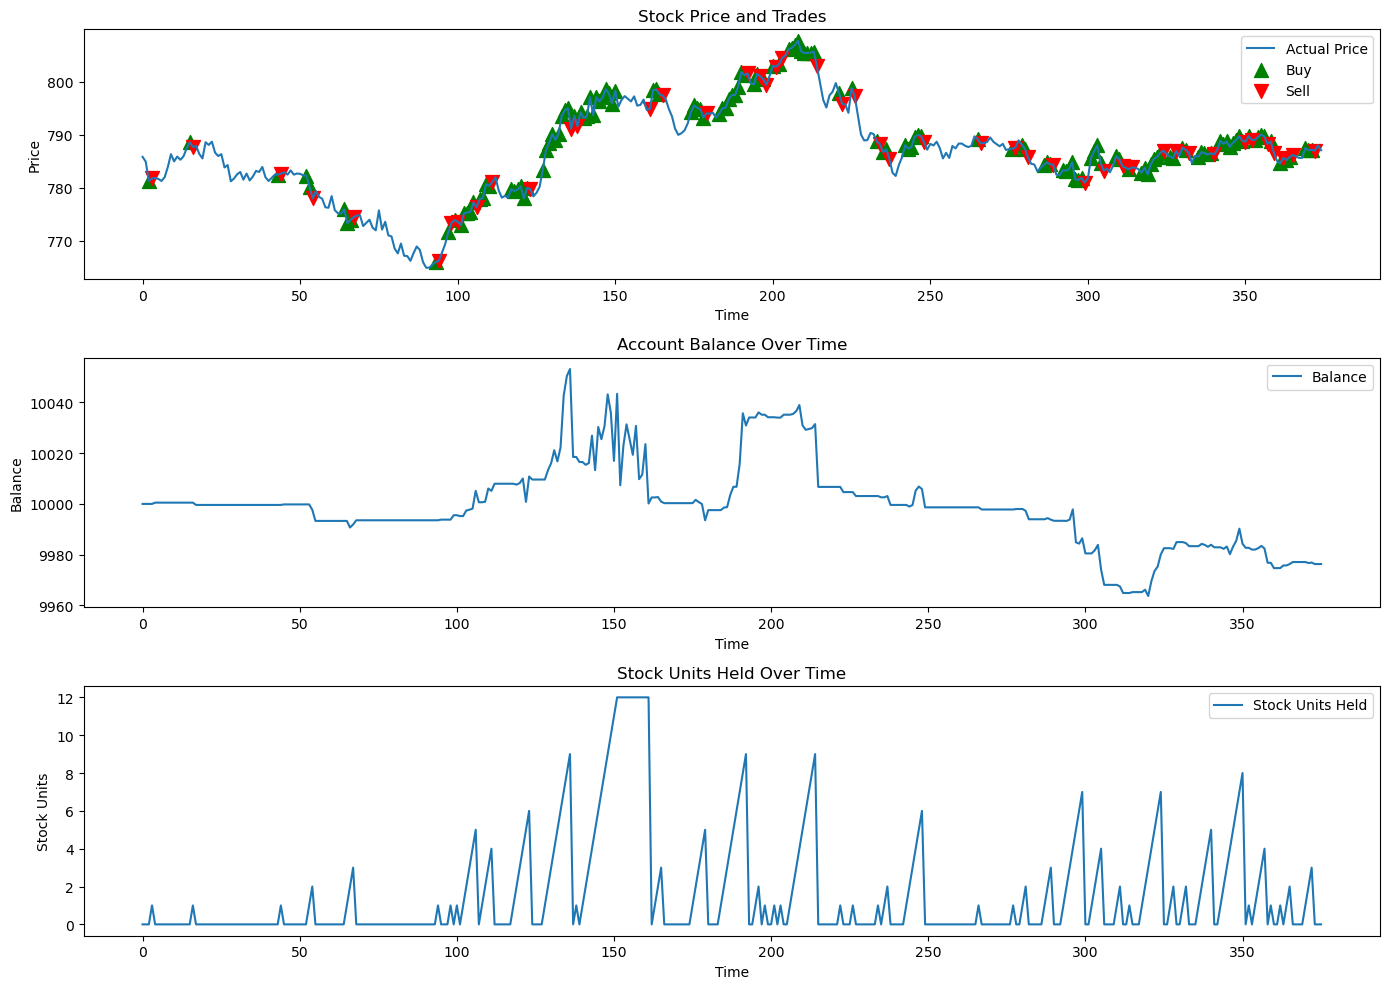

In [57]:
print("Without Retraining:")
visualize_trading_strategy_continuous(init_amount, y_test_continuous_rescaled[-test_size:], predictions_no_retraining_rescaled[-test_size:])
print()
print("With Retraining:")
visualize_trading_strategy_continuous(init_amount, y_test_continuous_rescaled[-test_size:], predictions_with_retraining_rescaled[-test_size:])

In [58]:
print("Without Retraining:")
continuous_trading_strategy(init_amount, y_test_continuous_rescaled[-test_size:], predictions_no_retraining_rescaled[-test_size:])
print()
print("With Retraining:")
continuous_trading_strategy(init_amount, y_test_continuous_rescaled[-test_size:], predictions_with_retraining_rescaled[-test_size:])

Without Retraining:
Initial Amount: 10000
Final Balance:  9968.300
Total Transactions: 204
Buys: 158, Sells: 46
Trading Duration: 31.17 hours
Trades per hour: 6.545454545454545
Mean Gain/Loss Percentage per transaction: -0.00155%
Gain/Loss Percentage: -0.32%
Baseline Scenario:
Baseline Gain/Loss Percentage: 0.16%

With Retraining:
Initial Amount: 10000
Final Balance:  9976.300
Total Transactions: 193
Buys: 147, Sells: 46
Trading Duration: 31.17 hours
Trades per hour: 6.192513368983957
Mean Gain/Loss Percentage per transaction: -0.00123%
Gain/Loss Percentage: -0.24%
Baseline Scenario:
Baseline Gain/Loss Percentage: 0.16%


## Derivative accuracy

In [59]:
def to_binary_classification(prices):
    prices = prices.flatten()
    return np.where(np.diff(prices, prepend=prices[0]) > 0, 1, 0)

In [60]:
y_test_binary = to_binary_classification(y_test_continuous_rescaled)
predictions_no_retraining_binary = to_binary_classification(predictions_no_retraining_rescaled)
predictions_with_retraining_binary = to_binary_classification(predictions_with_retraining_rescaled)

In [61]:
classification_report_no_retraining = classification_report(y_test_binary, predictions_no_retraining_binary)

# Calculate classification metrics for predictions with retraining
classification_report_with_retraining = classification_report(y_test_binary, predictions_with_retraining_binary)

# Print the results
print("Classification Report for Predictions without Retraining:")
print(classification_report_no_retraining)

print("\nClassification Report for Predictions with Retraining:")
print(classification_report_with_retraining)

Classification Report for Predictions without Retraining:
              precision    recall  f1-score   support

           0       0.51      0.50      0.51      4993
           1       0.48      0.49      0.49      4693

    accuracy                           0.50      9686
   macro avg       0.50      0.50      0.50      9686
weighted avg       0.50      0.50      0.50      9686


Classification Report for Predictions with Retraining:
              precision    recall  f1-score   support

           0       0.51      0.50      0.51      4993
           1       0.48      0.49      0.49      4693

    accuracy                           0.50      9686
   macro avg       0.50      0.50      0.50      9686
weighted avg       0.50      0.50      0.50      9686



## Inference on train

In [32]:
model_continuous = tf.keras.models.load_model('continuous_model.h5')

In [68]:
y_pred_continuous = model_continuous.predict(X_train)
# Convert continuous predictions to binary predictions for evaluation
y_pred_binary_from_cont = (y_pred_continuous[:-1] < y_pred_continuous[1:]).astype(int)

3755/3755 [==============================] - 334s 89ms/step


In [69]:
# Evaluate continuous model converted to binary
print("Continuous Model Converted to Binary Classification Report:")
print(classification_report(y_train_binary[:-1], y_pred_binary_from_cont))

Continuous Model Converted to Binary Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.58      0.59     62955
           1       0.55      0.58      0.57     57204

    accuracy                           0.58    120159
   macro avg       0.58      0.58      0.58    120159
weighted avg       0.58      0.58      0.58    120159



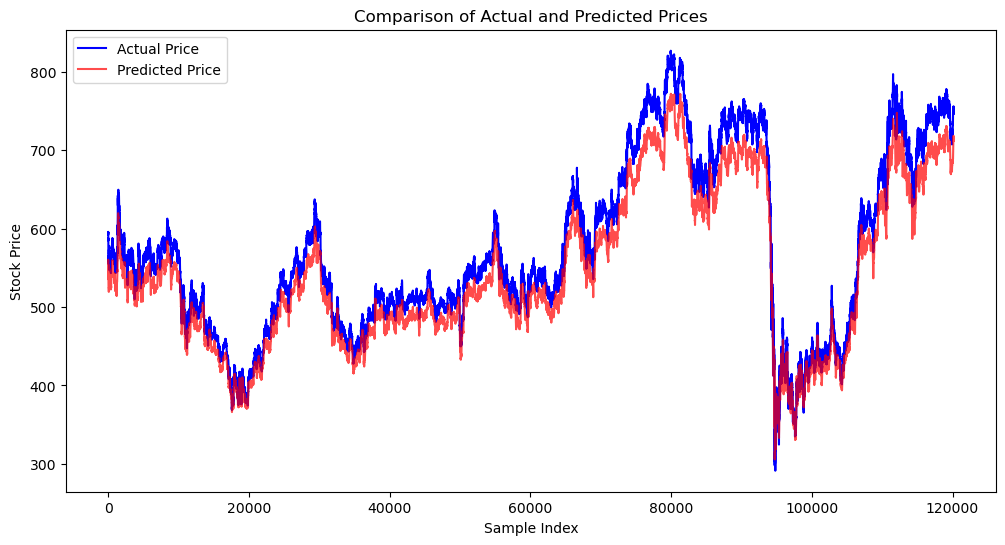

In [35]:
# Train
# Rescale the outputs back to the original scale
y_train_continuous_rescaled = close_scaler.inverse_transform(y_train_continuous.reshape(-1, 1))
y_pred_continuous_rescaled = close_scaler.inverse_transform(y_pred_continuous.reshape(-1, 1))

# Visualization of prediction vs actual for the continuous model
plt.figure(figsize=(12, 6))
plt.plot(y_train_continuous_rescaled, label='Actual Price', color='blue')
plt.plot(y_pred_continuous_rescaled, label='Predicted Price', color='red', alpha=0.7)
plt.title('Comparison of Actual and Predicted Prices')
plt.xlabel('Sample Index')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [36]:
continuous_trading_strategy(init_amount, y_train_continuous_rescaled, y_pred_continuous_rescaled)

Initial Amount: 10000
Final Balance:  12651.150
Total Transactions: 71949
Buys: 56723, Sells: 15226
Trading Duration: 10013.25 hours
Trades per hour: 7.185379372331661
Mean Gain/Loss Percentage per transaction: 0.00037%
Gain/Loss Percentage: 26.51%
Baseline Scenario:
Baseline Gain/Loss Percentage: 26.13%


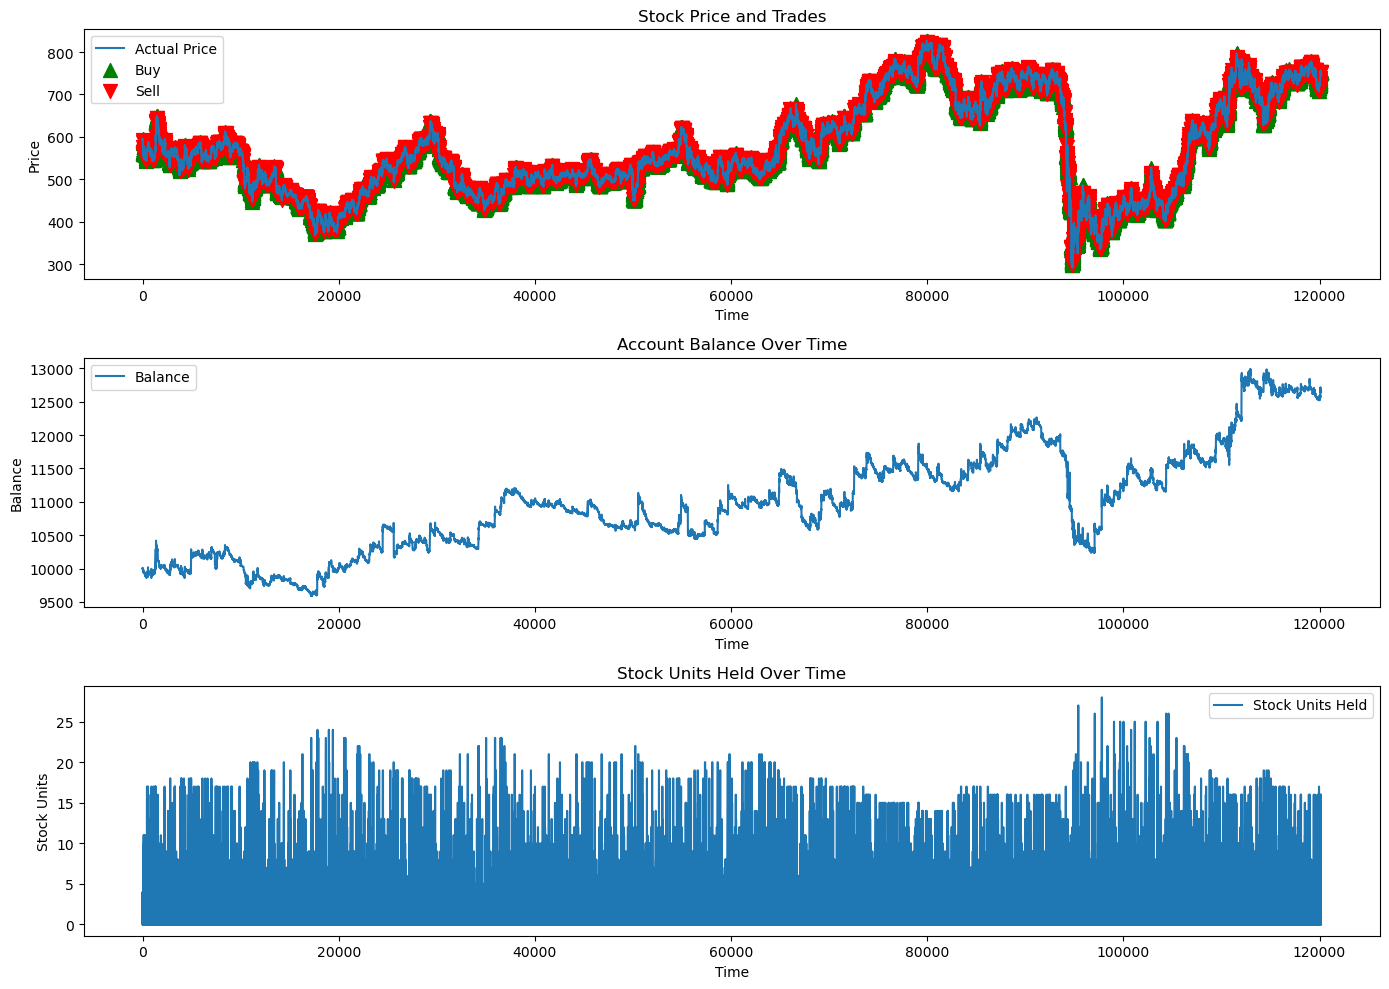

In [37]:
visualize_trading_strategy_continuous(init_amount, y_train_continuous_rescaled, y_pred_continuous_rescaled)

### shorter timespan

In [70]:
# Evaluate continuous model converted to binary
print("Continuous Model Converted to Binary Classification Report:")
print(classification_report(y_train_binary[:1000], y_pred_binary_from_cont[:1000]))

Continuous Model Converted to Binary Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.65      0.62       512
           1       0.59      0.54      0.56       488

    accuracy                           0.59      1000
   macro avg       0.59      0.59      0.59      1000
weighted avg       0.59      0.59      0.59      1000



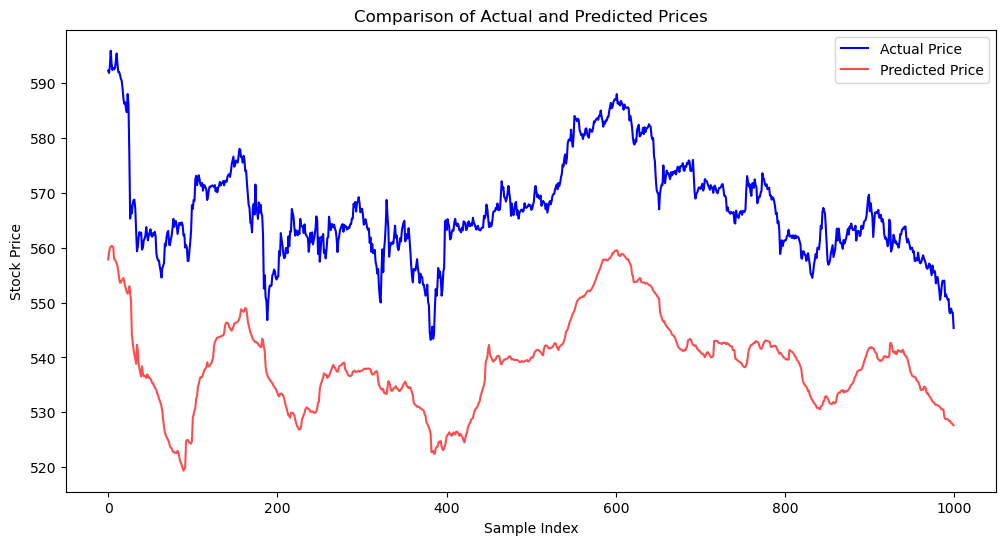

In [39]:
# Visualization of prediction vs actual for the continuous model
plt.figure(figsize=(12, 6))
plt.plot(y_train_continuous_rescaled[:1000], label='Actual Price', color='blue')
plt.plot(y_pred_continuous_rescaled[:1000], label='Predicted Price', color='red', alpha=0.7)
plt.title('Comparison of Actual and Predicted Prices')
plt.xlabel('Sample Index')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [40]:
continuous_trading_strategy(init_amount, y_train_continuous_rescaled[:1000], y_pred_continuous_rescaled[:1000])

Initial Amount: 10000
Final Balance:  9913.600
Total Transactions: 518
Buys: 405, Sells: 113
Trading Duration: 83.25 hours
Trades per hour: 6.222222222222222
Mean Gain/Loss Percentage per transaction: -0.00167%
Gain/Loss Percentage: -0.86%
Baseline Scenario:
Baseline Gain/Loss Percentage: -7.92%


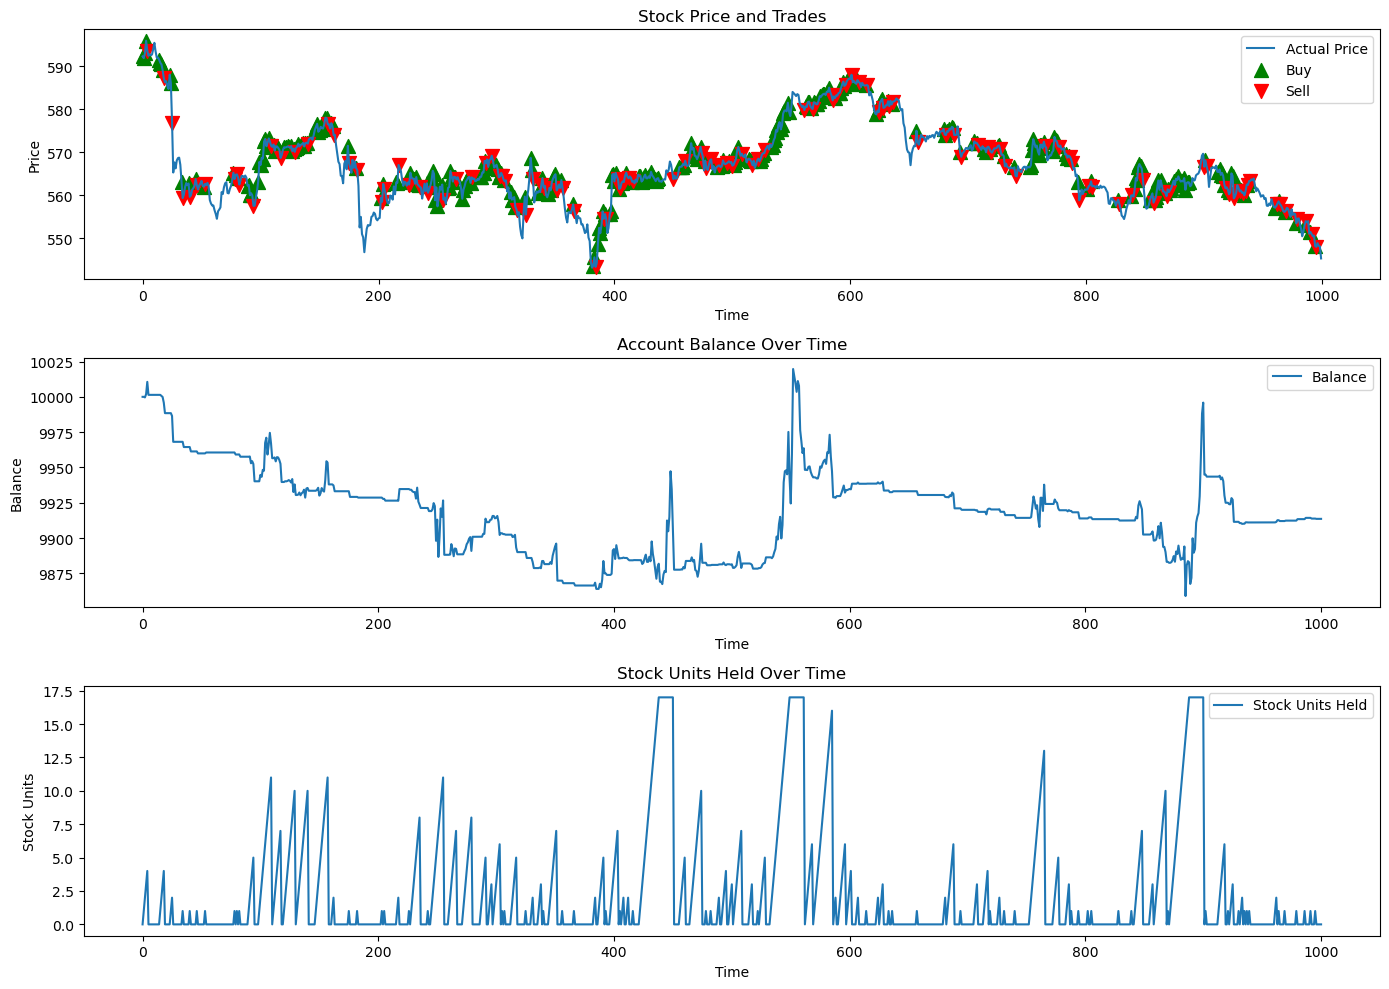

In [41]:
visualize_trading_strategy_continuous(init_amount, y_train_continuous_rescaled[:1000], y_pred_continuous_rescaled[:1000])